# NLP with 🤗 Hugging Face

## Text Classification: Transfer Learning vs Zero-Shot Classifier

🤗 [Hugging Face](https://huggingface.co/) is, in my opinion, one of the best things that has happened to Data Science over the past few years. From generalizing access to state-of-the-art NLP models with the [`transformers`](https://huggingface.co/transformers/) library to [distillation [1]](https://arxiv.org/abs/1910.01108), they are having a huge impact on the field. I recently found out about "Zero-Shot Classification". These models are classifiers that do not need any fine-tuning, apart from being told which classes it should predict. They are built on top of Natural Language Inference models, whose task is determining if sentence *A* implies, contradicts or has nothing to do with sentence *B*. This excellent [blog post](https://joeddav.github.io/blog/2020/05/29/ZSL.html) written by 🤗 Hugging Face researcher Joe Davison provides more in-depth explanations.  
  
Here is an example:

In [1]:
# %pip install pandas
# %pip install torch
# %pip install scipy
# %pip install transformers
# %pip install sklearn
# %pip install matplotlib
# %pip install seaborn
# %pip install numpy
# %pip install pyarrow

In [1]:
# transformers 4.20.1 in this notebook
from transformers import pipeline

# By default, the pipeline runs on the CPU (device=-1). Set device to 0 to use the GPU (and to 1 for the second GPU, etc...)
classifier = pipeline("zero-shot-classification", device=0)
classifier(
    "Parallel processing with GPUs is the savior of Deep Learning",
    candidate_labels=["education", "politics", "technology"],
)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


{'sequence': 'Parallel processing with GPUs is the savior of Deep Learning',
 'labels': ['technology', 'education', 'politics'],
 'scores': [0.9941806197166443, 0.0031009134836494923, 0.0027184567879885435]}

The classifier guessed that the sentence is about tech with a probability over 99%. **But how does Zero-Shot classification compare with plain "old" fine-tuned text classification?**

### I) BBC News dataset

Let's build a classifier of news articles labeled *business*, *entertainment*, *politics*, *sport* and *tech*. Available [here](http://mlg.ucd.ie/datasets/bbc.html), the dataset consists of 2225 documents from the BBC news website from the years 2004/2005. It was originally built for a Machine Learning paper about clustering [[2]](http://mlg.ucd.ie/files/publications/greene06icml.pdf).  
  
Articles are individual .txt files spread into 5 folders, one for each folder. The listing below puts articles/labels into a `pandas.DataFrame()`.

In [1]:
# Utilities to handle directories, files, paths, etc...
from os import listdir
from os.path import isdir, isfile, join
from pathlib import Path

# Most original import ever
import pandas as pd

path_to_bbc_articles="bbc"
labels=[] # labels for the text classification
label_dataframes=[] # for each label, get the articles into a dataframe

for label in [dir for dir in listdir(path_to_bbc_articles) if isdir(join(path_to_bbc_articles, dir)) and dir!=".ipynb_checkpoints"]:
    labels.append(label)
    label_path=join(path_to_bbc_articles, label)
    articles_list=[]
    for article_file in [file for file in listdir(label_path) if isfile(join(label_path, file))]:
        article_path=join(label_path, article_file)
        article=Path(article_path).read_text(encoding="ISO-8859-1") # Tried utf-8 (of course) but encountered error
        # Stackoverflow said "try ISO-8859-1", it worked (dataset is 11 years old)
        articles_list.append(article)
    label_dataframes.append(pd.DataFrame({'label': label, 'article': articles_list}))
    
df=pd.concat(label_dataframes, ignore_index=True) # Concatenate all the dataframes

In [2]:
# Number of articles per label
df.value_counts('label')

label
sport            511
business         510
politics         417
tech             401
entertainment    386
dtype: int64

We will need integer labels to feed the transformer model:

In [3]:
df['label_int']=df['label'].apply(lambda x:labels.index(x))

Here are 5 random rows from the final dataframe:

In [4]:
df.sample(5, random_state=42)

,label,article,label_int
414,business,UK house prices dip in November\n\nUK house pr...,0
420,business,LSE 'sets date for takeover deal'\n\nThe Londo...,0
1644,sport,Harinordoquy suffers France axe\n\nNumber eigh...,3
416,business,Barclays shares up on merger talk\n\nShares in...,0
1232,politics,Campaign 'cold calls' questioned\n\nLabour and...,2


### II) Fine-tuning a pretrained text classifier

After building the train/validation/test sets, we will go straight the point by using the [`DistilBERT`](https://huggingface.co/transformers/model_doc/distilbert.html) pre-trained transformer model (and its tokenizer).

> *It is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances.* 

In [5]:
# Train set, validation set and test set
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
train, val = train_test_split(train_val, test_size=0.2, random_state=42, shuffle=True)

# Reset the indexes of the 3 pandas.DataFrame()
train, val, test = map(lambda x:x.reset_index(drop=True), [train, val, test])

#### Tokenize

Loading DistilBERT's tokenizer, we can see that this transformer model takes input sequences composed of up to 512 tokens: 

In [6]:
# Load Distilbert's tokenizer
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.max_model_input_sizes

{'distilbert-base-uncased': 512,
 'distilbert-base-uncased-distilled-squad': 512,
 'distilbert-base-cased': 512,
 'distilbert-base-cased-distilled-squad': 512,
 'distilbert-base-german-cased': 512,
 'distilbert-base-multilingual-cased': 512}

How does this compare with the lengths of the tokenized BBC articles?

In [7]:
tokenized_articles_lengths=pd.DataFrame({'length': list(map(len, tokenizer(df['article'].to_list(), truncation=False, padding=False)['input_ids']))})
tokenized_articles_lengths.describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


,length
count,2225.000000
mean,487.627416
std,293.625901
min,108.000000
25%,314.000000
50%,423.000000
75%,592.000000
max,5303.000000


The articles are, on average, 488-token-long. The longest news is composed of 5303 tokens. This means that an important part of the articles will be truncated before being fed to the transformer model. Here is the distribution of the lengths:

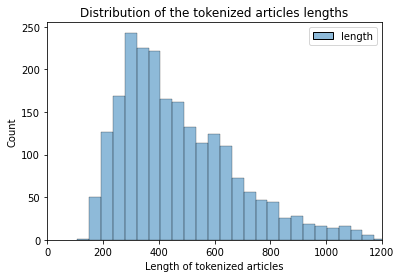

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.histplot(tokenized_articles_lengths)
ax.set(xlabel='Length of tokenized articles', ylabel='Count', xlim=(0, 1200), title='Distribution of the tokenized articles lengths')
plt.show()

# As shown on datatrigger.org/nlp_hugging_face:

# fig, ax = plt.subplots(figsize=(16, 16))
# ax=sns.histplot(tokenized_articles_lengths, palette='dark')
# ax.set(xlim=(0, 1200))
# ax.set_xticks(range(0, 1200, 100))
# ax.set_title('Distribution of the tokenized articles lengths', fontsize=24, pad=20)
# ax.set_xlabel('Length of tokenized articles', fontsize = 18, labelpad = 10)
# ax.set_ylabel('Count', fontsize = 18, labelpad = 10)
# ax.tick_params(labelsize=14)
# plt.savefig('tokenized_articles_length_distribution.png', bbox_inches='tight');

In [9]:
from scipy.stats import percentileofscore
print(f'Percentile of length=512: {int(percentileofscore(tokenized_articles_lengths["length"],512))}th')

Percentile of length=512: 64th


About 36% of the articles will be truncated to fit the 512-token limit of DistilBERT. The truncation is mandatory, otherwise the model crashes. We will use fixed padding for the sake of simplicity here.

#### Fine-tune DistilBERT

The train/validation/test sets must be procesμsed to work with either PyTorch or TensorFlow.

In [10]:
# Format the train/validation/test sets
train_encodings = tokenizer(train['article'].to_list(), truncation=True, padding=True)
val_encodings = tokenizer(val['article'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test['article'].to_list(), truncation=True, padding=True)

import torch

class BBC_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BBC_Dataset(train_encodings, train['label_int'].to_list())
val_dataset = BBC_Dataset(val_encodings, val['label_int'].to_list())
test_dataset = BBC_Dataset(test_encodings, test['label_int'].to_list())

In [11]:
# Fine-tuning
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
)

# The number of predicted labels must be specified with num_labels
# .to('cuda') to do the training on the GPU
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(labels)).to('cuda')

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [12]:
trainer.train()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1601
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 603


Step,Training Loss
500,0.140300


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=603, training_loss=0.118651934919468, metrics={'train_runtime': 242.7883, 'train_samples_per_second': 19.783, 'train_steps_per_second': 2.484, 'total_flos': 636274955105280.0, 'train_loss': 0.118651934919468, 'epoch': 3.0})

In [13]:
trainer.save_model("bbc_news_model")

Saving model checkpoint to bbc_news_model
Configuration saved in bbc_news_model/config.json
Model weights saved in bbc_news_model/pytorch_model.bin


In [14]:
# Generate predictions for the test set
predictions=trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 223
  Batch size = 4


#### Accuracy

In [15]:
import numpy as np
test_results=test.copy(deep=True)
test_results["label_int_pred_transfer_learning"]=np.argmax(predictions.predictions, axis=-1)
test_results['label_pred_transfer_learning']=test_results['label_int_pred_transfer_learning'].apply(lambda x:labels[x])

In [16]:
accuracy=1-(len(test_results[test_results["label"]!=test_results["label_pred_transfer_learning"]])/len(test_results))
print(f'The accuracy of the fine-tuned DistilBERT transformer model on the test set is {100*accuracy:.2f}%.')

The accuracy of the fine-tuned DistilBERT transformer model on the test set is 98.65%.


#### Misclassified articles

In [17]:
with pd.option_context('display.max_colwidth', None):
    display(test_results[test_results["label"]!=test_results["label_pred_transfer_learning"]])

label  \
63        business   
120  entertainment   
211       politics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

There are only 3 errors on the test set, out of 56 articles. Besides, the misclassifications actually make sense because the articles could very well have been labelled differently:

* The first article was put into the category *business* by the labeller whereas the model predicted *politics*. But since it is about the richest countries' ministers/presidents writing off some African countries' debt, it is also definitely about politics
* The second article is about the censorship of a play in Uganda, so the predicted label *politics* could actually be deemed more relevant than the original label, *entertainment*
* The third misclassified article is about the impact of IT on UK's firms, mainly through *e*-commerce, and the role of the government in this area. So *politics* (actual), *tech* (predicted) and even *business* are fine as labels

### III) Zero-Shot Classification

We'll use the appropriate [`transformers.pipeline`](https://huggingface.co/transformers/main_classes/pipelines.html) to compute the predicted class for each article.

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", device=0) # device=0 means GPU

In [19]:
# Compute the predicted label for each article
test_results['label_pred_zero_shot']=test_results['article'].apply(lambda x:classifier(x, candidate_labels=labels)['labels'][0])

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/pipelines/base.py:1012: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [20]:
# Reorder columns and save results
test_results=test_results[['article', 'label', 'label_pred_transfer_learning', 'label_pred_zero_shot']]
test_results.to_parquet("test_results.parquet")

In [21]:
test_results=pd.read_parquet("test_results.parquet")

In [22]:
error_rate=len(test_results[test_results["label"]!=test_results["label_pred_zero_shot"]])/len(test_results)
print(f'Accuracy of the Zero-Shot classifier: {round(100*(1-error_rate), 2)} %')

Accuracy of the Zero-Shot classifier: 58.74 %


The Zero-Shot classifier does a really bad job compared with the fine-tuned model. However, given the number of labels &mdash; 5 &mdash; this result is not that catastrophic. It is well above the 20% a random classifier would achieve (assuming balanced classes). Let's have a look at a few random articles uncorrectly labeled by the Zero-Shot classifier:

In [23]:
test_results[test_results["label"]!=test_results["label_pred_zero_shot"]].sample(15, random_state=42)

,article,label,label_pred_transfer_learning,label_pred_zero_shot
104,Holmes back on form in Birmingham\n\nDouble Ol...,sport,sport,tech
57,Asylum children to face returns\n\nThe UK gove...,politics,politics,tech
141,Tobacco giants hail court ruling\n\nUS tobacco...,business,business,politics
173,Aviator 'creator' in Oscars snub\n\nThe man wh...,entertainment,entertainment,business
2,Harinordoquy suffers France axe\n\nNumber eigh...,sport,sport,business
72,Solutions to net security fears\n\nFake bank e...,tech,tech,sport
103,Turkey-Iran mobile deal 'at risk'\n\nTurkey's ...,business,business,politics
165,Police praise 'courageous' Ozzy\n\nRock star O...,entertainment,entertainment,business
21,Almagro continues Spanish surge\n\nUnseeded Ni...,sport,sport,business
115,Lewis-Francis eyeing world gold\n\nMark Lewis-...,sport,sport,business


There does not seem to be a particularly problematic class, although such a assertion would require further investigation. But the length of the news could lead to poor performance. We can read about this on the [🤗 Hugging Face forum](https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681/85). Joe Davison, 🤗 Hugging Face developer and creator of the Zero-Shot pipeline, says the following:

> *For long documents, I don’t think there’s an ideal solution right now. If truncation isn’t satisfactory, then the best thing you can do is probably split the document into smaller segments and ensemble the scores somehow.*

We'll try another solution: summarizing the article first, then Zero-Shot classifying it.

### IV) Summarization + Zero-Shot Classification

The easiest way to do this would have been to line up the `SummarizationPipeline` with the `ZeroShotClassificationPipeline`. This is not possible, at least with my version of the `transformers` library (3.5.1). The reason for this is that the `SummarizationPipeline` uses Facebook's BART model, whose maximal input length is 1024 tokens. However, `transformers`'s tokenizers, including `BartTokenizer`, do not automatically truncate sequences to the max input length of the corresponding model. As a consequence, the `SummarizationPipeline` crashes whenever sequences longer than 1024 tokens are given as inputs. Since there are quite a few long articles in the BBC dataset, we will have to make a custom summarization pipeline that truncates news longers than 1024 tokens.

In [ ]:
# Import the tokenizer and model for summarization (the same that are used by default in Hugging Face's summarization pipeline)
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to('cuda') # Run on the GPU
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [33]:
# Custom summarization pipeline (to handle long articles)
def summarize(text):
    # Tokenize and truncate
    inputs = tokenizer_bart([text], truncation=True, max_length=1024, return_tensors='pt').to('cuda')
    # Generate summary between 10 (by default) and 50 characters
    summary_ids = model_bart.generate(inputs['input_ids'], num_beams=4, max_length=60, early_stopping=True)
    # Untokenize
    return([tokenizer_bart.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0])

In [34]:
# Apply summarization then zero-shot classification to the test set
test_results['label_pred_sum_zs']=test_results['article'].apply(lambda x:classifier(summarize(x), candidate_labels=labels)['labels'][0])

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/pipelines/base.py:1012: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [35]:
test_results.to_parquet("test_results.parquet")

In [36]:
error_rate_sum_zs=len(test_results[test_results["label"]!=test_results["label_pred_sum_zs"]])/len(test_results)
print(f'Accuracy of the Summmarization+Zero-Shot classifier pipeline: {round(100*(1-error_rate_sum_zs), 2)} %')

Accuracy of the Summmarization+Zero-Shot classifier pipeline: 73.54 %


Adding the summarization before the zero-shot classification, **the accuracy jumped by ~15%**! Let us remember that there was no training whatsoever. From this perspective, a 73.5% accuracy looks pretty good. This result could probably be enhanced by tuning the summarizer's parameters regarding beam search or maximal length.

### V) Conclusion

Text classification is a piece of cake using 🤗 Hugging Face's pre-trained models: fine-tuning DistilBERT is fast (using a GPU), easy and it resulted in a 98.65% accuracy on the BBC News test set. Although this result should be confirmed with other train-test split (only 56 articles in the test set), it is absolutely remarkable. The raw Zero-Shot Classification pipeline from the `transformers` library could not compete at all with such a performance, ending up with a ~59% accuracy on the same test set. Nonetheless, this result is still decent considering the complete absence of training required by this method.  
  
Given the substantial length of the BBC News articles, we tried summarizing them before performing the Zero-Shot classification, still using the beloved `transformers` library. This method resulted in a +15% increase of accuracy. Another way would have been to carry out sentence segmentation before the Zero-Shot classification, and averaging the prediction over all an article's sentences.

We end up with two text classifiers:
* One that requires training and yields a 98.65% accuracy
* One that does not require any training, but yields a ~73.5% accuracy

Long live 🤗 Hugging Face!

## References

[[1]](https://arxiv.org/abs/1910.01108) Victor Sanh, Lysandre Debut, Julien Chaumond, Thomas Wolf. *DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter.* (Hugging Face, 2020)  
  
[[2]](http://mlg.ucd.ie/files/publications/greene06icml.pdf) D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.